In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
df = pd.read_csv("../Data/Hourly consumtpion per cluster.csv")
df["time"] = df["time"].astype(str).str.zfill(3)
df.index = df["time"]
df["day"] = df["time"].str[:1]
df["hour"] = df["time"].str[1:]
df.drop(['time','Unnamed: 0'], axis = 1, inplace = True)
df.head()


,Cluster,consumption_kWh,CO2_intensity,day,hour
time,,,,,
000,0,33.813385,206.339623,0,00
001,0,37.310308,214.980769,0,01
002,0,29.514769,214.673077,0,02
003,0,31.131462,215.509615,0,03
004,0,39.650769,216.461538,0,04


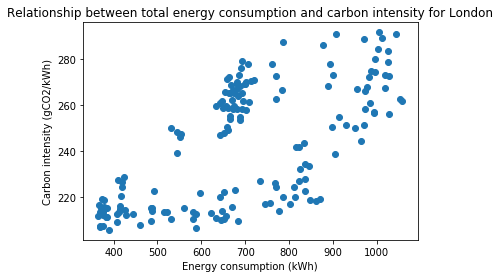

In [6]:
a = df.groupby('time')['consumption_kWh'].apply(lambda x: np.sum(x)).to_frame()

z = df.iloc[range(0,168),-3]
a["CO2_intensity"] = z

plt.scatter(x = a['consumption_kWh'], y = a['CO2_intensity'])
plt.title("Relationship between total energy consumption and carbon intensity for London")
plt.xlabel("Energy consumption (kWh)")
plt.ylabel("Carbon intensity (gCO2/kWh)")
plt.savefig("Carbon Intensity vs Consumption London.png")

In [5]:
a['consumption_kWh'].corr(a['CO2_intensity'])

0.6462240151104416

## Reduction of energy consumption 

Evaluate the impact a X% reduction in energy consumption of a cluster during evening peak could have on overall consumption and co2 emissions. 

We look at cluster 5 between 6 and 10 pm

In [127]:
eff = df.copy()

eff["Efficiency"] = 1
eff.head()

eff["Efficiency"] = eff["Efficiency"].where(
    ((eff["hour"] != "06") & (eff["hour"] != "07") & (eff["hour"] != "08")
    & (eff["hour"] != "09") &(eff["hour"] != "10")) | (eff["Cluster"] != 4 ) , 0.98)


In [128]:
eff["Emissions"] = eff["consumption_kWh"]*eff["CO2_intensity"]*eff["Efficiency"]
cluster_emissions = eff.groupby('Cluster')["Emissions"].apply(lambda x: np.sum(x
                                                                    )).to_frame()


<BarContainer object of 5 artists>

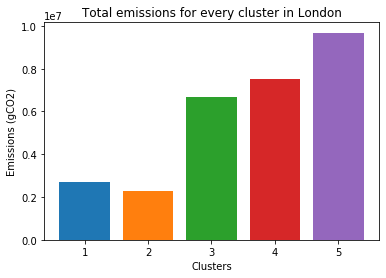

In [129]:
plt.title("Total emissions for every cluster in London")
plt.xlabel("Clusters")
plt.ylabel('Emissions (gCO2)')
plt.bar(cluster_emissions.index+1, cluster_emissions['Emissions'], color =["C0", "C1", "C2", "C3", "C4"])

In [130]:
total_emissions = cluster_emissions['Emissions'].sum()
total_emissions

28858493.4298305

In [ ]:
eff = df.copy()

decrease = np.arange(1, 0.45, -0.05)
result = [None]*len(decrease)
print(len(decrease))
eff["Efficiency"] = 1
eff.head()

for i in range(len(decrease)) : 
    
    eff["Efficiency"] = eff["Efficiency"].where(
        ((eff["hour"] != "06") & (eff["hour"] != "07") & (eff["hour"] != "08")
        & (eff["hour"] != "09") &(eff["hour"] != "10")) | (eff["Cluster"] != 4 ) , decrease[i])
    eff["Emissions"] = eff["consumption_kWh"]*eff["CO2_intensity"]*eff["Efficiency"]
    cluster_emissions = eff.groupby('Cluster')["Emissions"].apply(lambda x: np.sum(x
                                                                      )).to_frame()
    result[i] = cluster_emissions.iloc[4,0]

plt.xlim(1, 0.5)
plt.plot(decrease,result)
